<a href="https://colab.research.google.com/github/takao8/MLTSAProject/blob/master/code/feedforward_net_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHYS667 Final Project Neural Net Exploration

In this notebook, we create feedforward neural nets to forecast energy demand for the Nepool area.

In [0]:
pip install jupyterthemes  

In [3]:
import tensorflow as tf
import pylab as pl
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import math
import os
import xlrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from statsmodels.tsa.stattools import adfuller
import pathlib
import seaborn as sns
#from dataPrep import *  # self made file, make sure you keep this!!!
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reading in the Data

There's a lot of prep work and manipulation I did to get the data into the form that we wanted. 

In [0]:
weather_noaa = pd.read_csv('https://github.com/takao8/MLTSAProject/raw/master/data/boston_weather_cleaned.csv', index_col='DATE')
weather_noaa.index = pd.to_datetime(weather_noaa.index)

We drop two variables because they have TONS of missing values:

In [0]:
weather_noaa.loc[weather_noaa.index.year>2010].isna().sum()
weather_noaa = weather_noaa.drop(["HourlyAltimeterSetting", "HourlySeaLevelPressure"], axis=1)

Now we'll read in the load data:

In [0]:
mydata = pd.read_excel('https://github.com/takao8/MLTSAProject/blob/master/data/PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx?raw=true')
mydata = mydata[['Date', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]

In [0]:
# rounding everything to the nearest hour, since some values are a little off
mydata['Date'] = pd.to_datetime(mydata['Date']).dt.round('H')

In [0]:
# Creating dummy variables for month
a = [mydata['Date'][i].month for i in range(0, len(mydata))]
a = pd.get_dummies(a)
months = a.columns.values
for i in range(0, 11):
    mydata['Month%s' % (i+1)] = a.iloc[:, i]
    
# Creating dummy variables for hour
a = [mydata['Date'][i].hour for i in range(0, len(mydata))]
a = pd.get_dummies(a)
hours = a.columns.values
for i in range(0, 24):
    mydata['Hour%s' % (i+1)] = a.iloc[:, i]

In [0]:
# create dummy variable for holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=mydata["Date"].iloc[0], end=mydata["Date"].iloc[-1])
mydata["holiday"] = mydata["Date"].isin(holidays).astype(int)

In [0]:
# create dummy variable for weekend
l = []
for i in mydata["Date"]:
  if i.weekday() < 5:
    l.append(0)
  else:
    l.append(1)
mydata["weekend"] = l

Now we'll merge the datasets into each other.

In [0]:
mydata = pd.merge(weather_noaa, mydata, left_index=True, right_on="Date")
mydata = mydata.dropna()

In [0]:
# storing for later to unstandardize the data
mx = max(mydata['Nepool_Load_Hist'])
mn = min(mydata['Nepool_Load_Hist'])

In [0]:
t1 = preprocessing.minmax_scale(mydata[['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed',
       'KBOS_HID_HIST', 'Nepool_Load_Hist']], axis=0)

In [0]:
mydata[['HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed',
       'KBOS_HID_HIST', 'Nepool_Load_Hist']] = t1

In [0]:
#mydata.set_index("Date", inplace=True)

Text(0, 0.5, 'Energy Demand (MWh)')

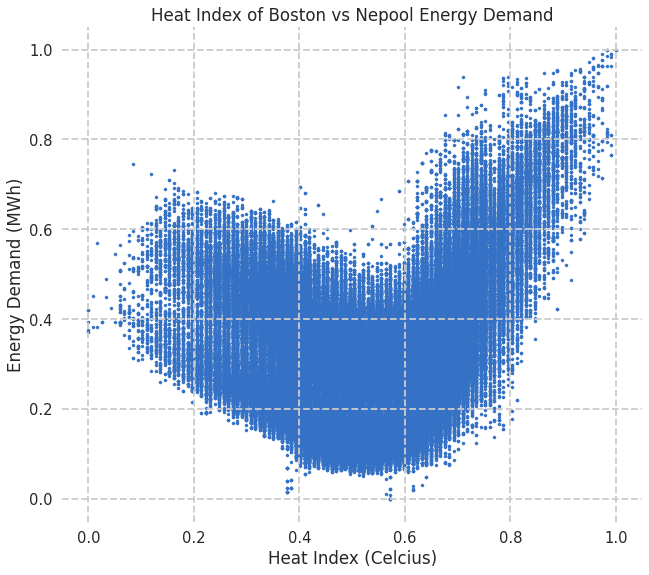

In [43]:
pl.scatter(mydata["KBOS_HID_HIST"], mydata["Nepool_Load_Hist"], s=10)
pl.title("Heat Index of Boston vs Nepool Energy Demand")
pl.xlabel("Heat Index (Celcius)")
pl.ylabel("Energy Demand (MWh)")

This is the classic load vs HID plot, which shows the correlation that goes on.

# Making the Neural Net

Now we'll create the neural net.  We're going to use a dense feedforward neural network for this purpose.

Creating basic training/validation/test sets

In [0]:
# By habit I make copies of the dataset for the training and test
# We don't need to do that for this instance, but I kept them anyway since they
# aren't affecting anything

mydataTr = mydata.copy()
mydataTr.set_index("Date", inplace=True)
mydataTe = mydata.copy()
mydataTe.set_index("Date", inplace=True)

In [0]:
# This is the basic structure of how we create the training/validation/testing
# We arbitrarily chose it here, but for our purposes, we'll use two years (24*2*365 datapoints)
# for training, one year (24*365 datapoints) for validation, and three months (24*90) for testing

trX = mydataTr.iloc[30000:50000, ]
trY = trX["Nepool_Load_Hist"]
trX = trX.drop(["Nepool_Load_Hist"], axis=1)
valX = mydataTe.iloc[50010:60000,]
valY = valX["Nepool_Load_Hist"]
valX = valX.drop(["Nepool_Load_Hist"], axis=1)
teX = mydataTe.iloc[60010:80000,]
teY = teX["Nepool_Load_Hist"]
teX = teX.drop(["Nepool_Load_Hist"], axis=1)

Model has 45 features (46 - 1 for dates)--make net appropriately

In [46]:
mydata.shape

(214032, 46)

In [0]:
# This is the basic model that we'll use -- 8 dense layers with dropout layers
# interwoven between the first 4.  

# the kernel-initializer defines how the weights are initialized.  I use he_uniform,
# although I don't know if there's a true best initializer for these purposes

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(41, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(37, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(35, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(33, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(28, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(20, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(5, activation="tanh", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1)])


In [0]:
# our callback -- min_delta is a variable we can mess with in the future, which
# defines how much lower a new validation error has to be below our current best
# before we record it as a new best

yes = tf.keras.callbacks.EarlyStopping(min_delta = 0, verbose=1, 
                                       patience=500, mode="min", restore_best_weights=True)

In [0]:
# for learning rate, 0.001 too heavy, 0.00001 too steep, 0.0005 just right. Using 
# the Adam optimizer, based off of exponential moving averages of the gradient

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='mse')

In [0]:
# to save the original weights, we initialize the model by predicting on a random
# test set.  This allows us to save the original weights and 

model.predict(teX);  # initialize the model
cur = model.get_weights()   # to reset the weights
model.save_weights("original")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [0]:
# the main dictionary that we use to store the forecasted and the true series for
# whichever time period we choose

vals = {}

In [0]:
# our main for loop to do the cross validation
# I always mess with things in this for loop to adjust for different circumstances
# For our purposes, we iterate over the following:
#
# y : years 
# m : months, usually 2 (February), 5 (May), 8 (August), 11 (November)
#
# With these 2 variables, we define the starting point as the first day of the 
# given month and year. We construct validation data on the previous year from 
# that point, training on 2 years before the validation, and testing on 3 months
# after the validation.

for y in range(2011, 2012):
  for m in [2]:
    strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]

    trX = mydataTr.iloc[strt-28000:strt-10000, ]
    trY = trX["Nepool_Load_Hist"]
    trX = trX.drop(["Nepool_Load_Hist"], axis=1)
    valX = mydataTe.iloc[strt-9000:strt,]
    valY = valX["Nepool_Load_Hist"]
    valX = valX.drop(["Nepool_Load_Hist"], axis=1)
    teX = mydataTe.iloc[strt:strt+4320,]
    teY = teX["Nepool_Load_Hist"]
    teX = teX.drop(["Nepool_Load_Hist"], axis=1)

    ## Train for each separation
    hist = model.fit(trX.to_numpy(), trY.to_numpy(), verbose=1, validation_data=(valX.to_numpy(), valY.to_numpy()), 
                 epochs=3000, batch_size=32, callbacks=[yes])
    
    # storing the predicted and true load:
    vals["%s %s predict" % (y, m)] = model.predict(teX)
    vals["%s %s actual" % (y, m)] = teY

    # save the trained model
    model.save_weights("%s %s weights" % (y, m))

    # clear session (an attempt to get over the memory leak that didn't work)
    tf.keras.backend.clear_session()

    # load the original weights to train again
    model.load_weights("original")

    # redefine the callback. we need to do this to reset the validation error
    # in the training. otherwise, it'll reload the previous iteration from the 
    # last training, even after we reset the weights.
    yes = tf.keras.callbacks.EarlyStopping(min_delta = 0, verbose=1, 
                                       patience=100, mode="min", restore_best_weights=True)

Epoch 1/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 2/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 3/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 4/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 5/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 6/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 7/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 8/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 9/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 10/3000
563/563 [==============================] - 2s 3ms/step - loss: 0.003

In [0]:
# now we'll save the dictionary data file with the forecasted/true load
# I changed the name of the file manually to be extra careful I didn't overwrite anything

import pickle
with open('2011.pickle', 'wb') as handle:
    pickle.dump(vals, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# just for future purposes, this is how we reload the same file
with open('2011.pickle', 'rb') as handle:
    vals = pickle.load(handle)

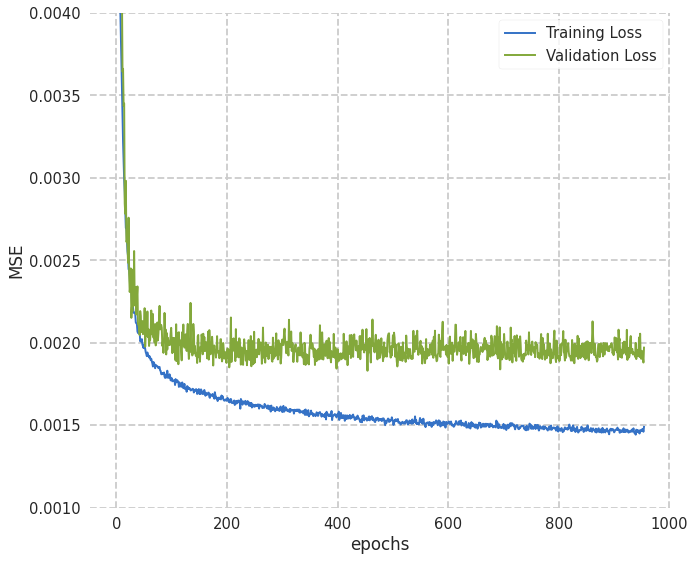

In [0]:
# plot of training error vs validation error
pl.plot(hist.history["loss"], label="Training Loss")
pl.plot(hist.history["val_loss"], label="Validation Loss")
pl.ylim([0.001, 0.004])
pl.xlabel("epochs")
pl.ylabel("MSE")
pl.legend()

The training vs validation isn't as good as I'd like to see.  I want to see a noticable increase in the validation data--however, because of the memory leak, it was hard to train past 1000 epochs.

# Analysis of results from fitting the nets

Now we'll produce some residual graphs based on our cross validation results

In [0]:
# this gets absolute percent errors (APEs) of our different forecasts against 
# the true values
l = []
rang = 90*24
for y in range(2010, 2012):
  with open('%s.pickle' % y, 'rb') as handle:
    b = pickle.load(handle)    # have it from 2010 - 2013?
  for m in [2, 5, 11]:
    l.append(np.abs((b["%s %s predict" % (y, m)].flatten()[:rang] - b["%s %s actual" % (y, m)].values[:rang]) /b["%s %s actual" % (y, m)].values[:rang]))

In [0]:
data = np.stack(l)

Our total MAPE:

In [0]:
np.mean(data)

0.09124355791259102

9.12% is our total MAPE.  Now looking at the residuals and the rolling MAPE:

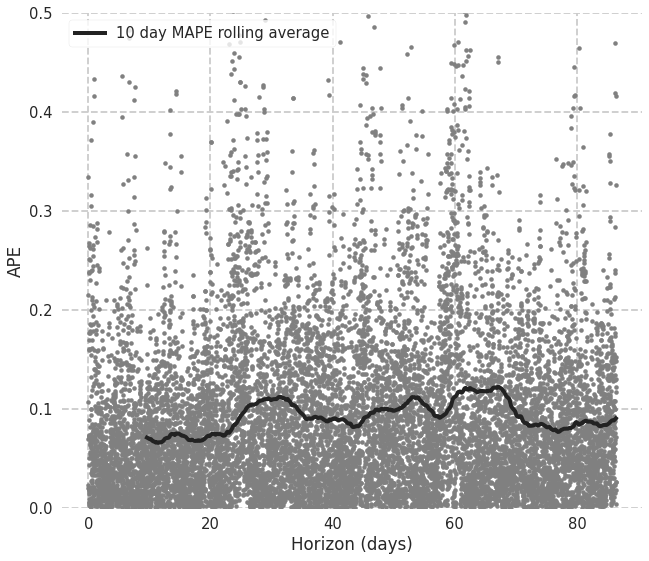

In [0]:

val = []
per = 10*24   # variable I used to play around with how long the MAPE did its rolling average over

for i in range(rang-per):
  val.append(np.mean(data[:, i:(i+per)]))

# our actual plotting:
fig, ax = pl.subplots()
pl.plot(data.T, '.', c='gray')
pl.plot(np.arange(per, rang), val, c='k', linewidth=4, label="10 day MAPE rolling average")
pl.ylabel("APE")
pl.xlabel("Horizon (days)")
pl.ylim([0, 0.5])
locs, labels=pl.xticks()
pl.xticks([0, 500, 1000, 1500, 2000], ["0", "20", "40", "60","80"])
pl.legend()

# Histogram of Residuals

Next we'll plot the histogram of all the residuals.  This, along with the residual plot before, give us a good indication of what's going wrong in the model.

In [0]:
# rounding everything to the nearest hour, since some values are a little off
mydata = pd.read_excel('PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx')  #stat
mydata = mydata[['Date', 'KBOS_WCL_HIST', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]
mydata['Date'] = pd.to_datetime(mydata['Date']).dt.round('H')
# Creating dummy variables for month
a = [mydata['Date'][i].month for i in range(0, len(mydata))]
a = pd.get_dummies(a)
months = a.columns.values
for i in range(0, 11):
    mydata['Month%s' % (i+1)] = a.iloc[:, i]
    
# Creating dummy variables for hour
a = [mydata['Date'][i].hour for i in range(0, len(mydata))]
a = pd.get_dummies(a)
hours = a.columns.values
for i in range(0, 24):
    mydata['Hour%s' % (i+1)] = a.iloc[:, i]

# create dummy variable for holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=mydata["Date"].iloc[0], end=mydata["Date"].iloc[-1])
mydata["holiday"] = mydata["Date"].isin(holidays).astype(int)

# create dummy variable for weekend
l = []
for i in mydata["Date"]:
  if i.weekday() < 5:
    l.append(0)
  else:
    l.append(1)
mydata["weekend"] = l

mydata = mydata.dropna()

In [0]:
mx = max(mydata['Nepool_Load_Hist'])
mn = min(mydata['Nepool_Load_Hist'])
t1 = preprocessing.minmax_scale(mydata[['KBOS_WCL_HIST',
       'KBOS_HID_HIST', 'Nepool_Load_Hist']], axis=0)
mydata[['KBOS_WCL_HIST',
       'KBOS_HID_HIST', 'Nepool_Load_Hist']] = t1

In [0]:
l = []
rang = 24*90
cheek = 240
for y in range(2010, 2012):
  for m in [2, 5, 8, 11]:
    model.load_weights("%s %s weights" % (y, m))
    strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]
    actual = mydata.iloc[strt:strt+rang]

    predict = model.predict(actual.drop(["Nepool_Load_Hist", "Date"], axis=1).to_numpy())
    actual = actual["Nepool_Load_Hist"]
    #pl.plot(np.abs((b["%s %s predict" % (y, m)].flatten() - b["%s %s actual" % (y, m)].values) /b["%s %s actual" % (y, m)].values),'.', c='k')
    l.append((predict.flatten() - actual.values))
    #(1 / len(b["2011 %s predict"])) * np.sum(np.abs((b["2011 %s predict"] - b["2011 %s actual"]) /b["2011 %s actual"]))


In [0]:
np.median(unnorm)

Text(-9000, 6500, 'Median: +200.03 MWh')

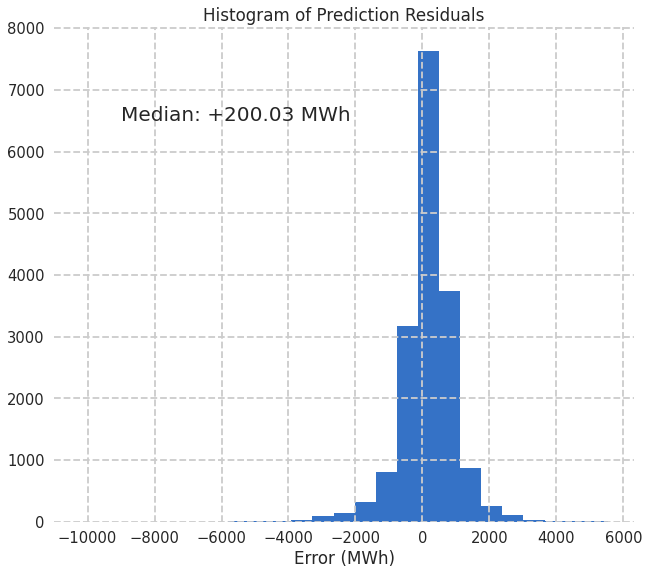

In [0]:
fig, ax = pl.subplots()
data = np.stack(l)
med = data.flatten()
unnorm = med*(mx - mn)
pl.hist(unnorm, bins=25)
pl.title("Histogram of Prediction Residuals")
pl.xlabel("Error (MWh)")
ax.text(-9000, 6500, "Median: +200.03 MWh", fontsize=20)``


Our histogram is leaning right, and indicates a tendancy to overpredict our values.

# Actual plots

We'll create actual plots to explore the issue further.

In [0]:
import matplotlib.dates as mdates
m = 5
y = 2011

In [0]:
mydata.set_index("Date", inplace=True)

In [0]:
d = mydata.loc[(mydata.index.year==y) & (m < mydata.index.month) & (mydata.index.month < m+4)].index
model.load_weights("%s %s weights" % (y, m))

In [0]:
actual = mydata.loc[(mydata.index.year==y) & (m < mydata.index.month) & (mydata.index.month < m+4)]["Nepool_Load_Hist"]

In [0]:
predict = model.predict(mydata.loc[(mydata.index.year==y) & (m < mydata.index.month) & (mydata.index.month < m+4)].drop("Nepool_Load_Hist", axis=1).to_numpy())

Text(0.5, 1.0, 'Predicted vs Actual June Energy Demand, 2011')

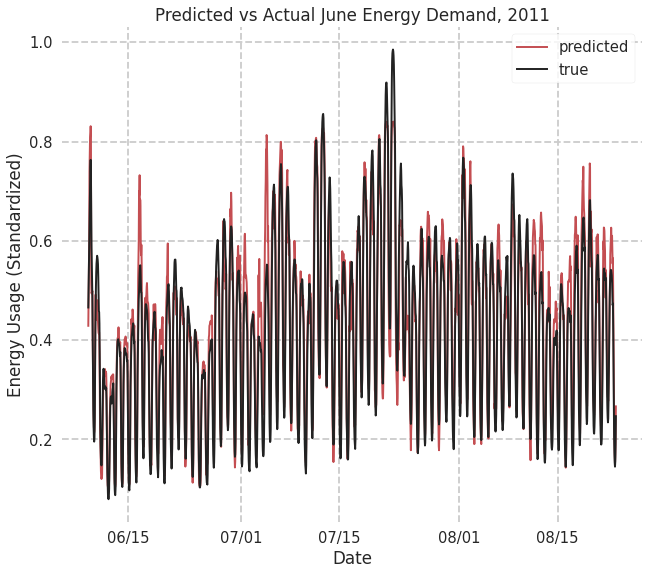

In [0]:
fig = pl.figure()
ax = fig.add_subplot(111)
s = 200
e = 2000
pl.plot(d[s:e], predict.flatten()[s:e], 'r', label="predicted")
pl.plot(d[s:e], actual.values[s:e], 'k', label="true")
pl.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
pl.ylabel("Energy Usage (Standardized)")
pl.xlabel("Date")
pl.title("Predicted vs Actual June Energy Demand, 2011")


# data exploration

Below is the work we did to explore the energy demand data.  There's a lot here, but it illustrates daily, weekly, and holiday seasonality behaviors in the data, as well as shows the transition of the daily load between the seasons of the year

In [0]:
explore = mydata[["Nepool_Load_Hist"]]
explore2 = mydata[["Nepool_Load_Hist", "KBOS_HID_HIST"]]

Text(0.5, 1.0, 'Daily Energy Fluctuations in February from 2010-2019, Nepool')

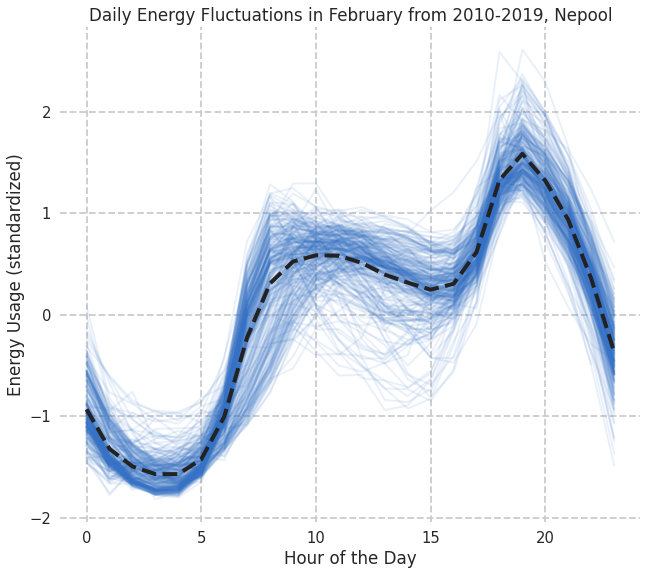

In [0]:
y = 2010
d=1
m=2
l = []
while y<2020:
  while d < 32:
    try:
      s = preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten())
      if len(s) < 24:
        pass
      else:
        l.append(s)
      pl.plot(preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten()), alpha=0.1, c='b')
    except:
      break
    d += 1
  d=1
  y+=1
pl.plot(np.arange(24), pd.DataFrame(np.stack(l)).mean(axis=0), '--', c='k', linewidth=4)
pl.xlabel("Hour of the Day")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuations in February from 2010-2019, Nepool")

In [0]:
x = explore["Nepool_Load_Hist"].loc[(explore.index.year==2019) & (explore.index.month==7) & ((explore.index.day > 1) & (explore.index.day < 7))].index

Text(0.5, 1.0, 'Daily Energy Fluctuations Around July 4th 2000-2019, Nepool')

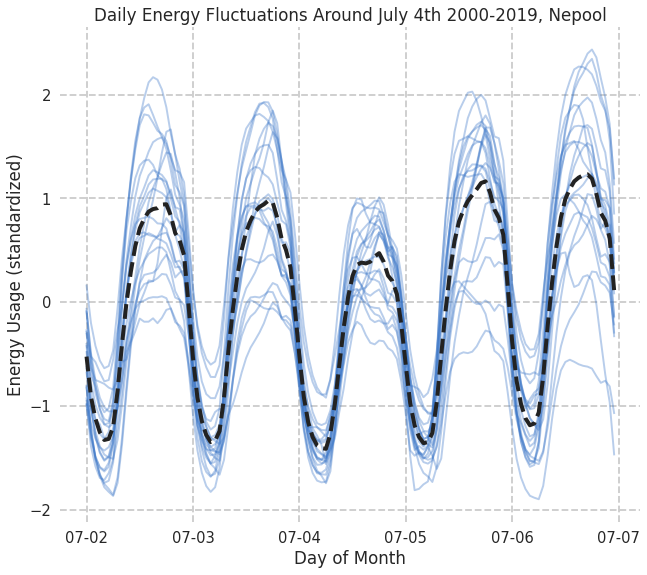

In [0]:
# july 4th
y = 2000
d=1
m=2
l = []
fig = pl.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

while y<2020:
  try:
    s = preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==7) & ((explore.index.day > 1) & (explore.index.day < 7))].values.flatten())
    if len(s) < 24:
      pass
    else:
      l.append(s)
    pl.plot(x, s, alpha=0.35, c='b')
  except:
    break
  y+=1
pl.plot(x, pd.DataFrame(np.stack(l)).mean(axis=0), '--', c='k', linewidth=4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
pl.xlabel("Day of Month")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuations Around July 4th 2000-2019, Nepool")

Text(0.5, 1.0, 'Weekly Energy Fluctuations in May from 2000-2019, Nepool')

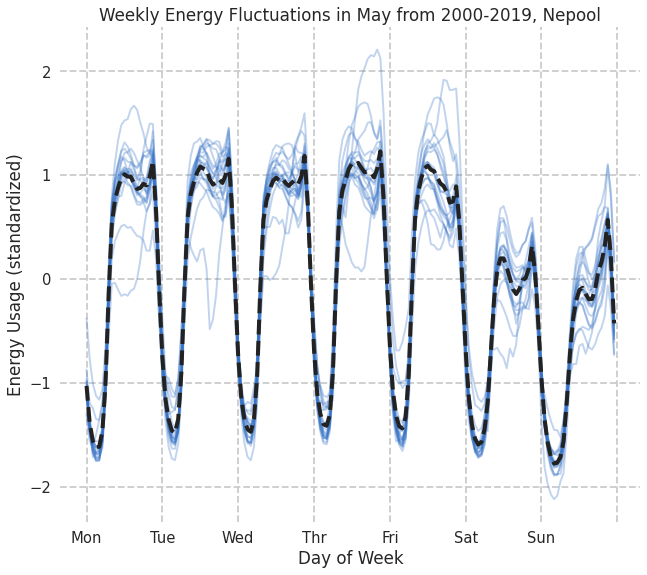

In [0]:
# day of week
fig = pl.figure()
ax = fig.add_subplot(111)
y = 2000
d=0
l = []
g = np.array([])
while y<2019:
  g = np.array([])
  try:
    s = explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==5) & (explore.index.dayofweek==0) & (explore.index.day < 8)]
    for i in range(1, 7):
      s = pd.concat([s, explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==5) & (explore.index.dayofweek==i) & (explore.index.day < 8)]])
    s = preprocessing.scale(s)
    if len(s) < 24:
      pass
    else:
      l.append(s)
  except:
    break

  pl.plot(x, s, alpha=0.3, c='b')
  d=0
  y+=1
pl.plot(x, pd.DataFrame(np.stack(l)).mean(axis=0), '--', c='k', linewidth=4)
labels = ["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]
ax.set_xticklabels(labels)
pl.xlabel("Day of Week")
pl.ylabel("Energy Usage (standardized)")
pl.title("Weekly Energy Fluctuations in May from 2000-2019, Nepool")

In [0]:
g = np.array([])
np.append(g, s)

array([-0.47571785, -0.8149438 , -0.98190628, -1.04971165, -1.00470925,
       -1.05054538, -1.10942244, -1.06069938, -0.94132759, -0.88393754,
       -0.95427519, -0.91738603, -0.86352687, -0.85189829, -0.75740132,
       -0.65421247, -0.48888322, -0.23975853,  0.01456139,  0.13643124,
        0.03558802, -0.11824642, -0.30332062, -0.6543618 , -0.52872152,
       -0.88177857, -1.01292204, -1.15271074, -1.21006656, -1.17061402,
       -1.17216636, -1.15005091, -0.926417  , -0.75707779, -0.43518893,
       -0.20198587,  0.05233715,  0.28368611,  0.40859844,  0.49666516,
        0.66800469,  0.8530571 ,  1.00070084,  1.0354248 ,  0.88889166,
        0.73837345,  0.49252765, -0.01610906,  0.85666576,  0.52212484,
        0.26194397,  0.19546074,  0.16300463,  0.06604693,  0.01224998,
        0.08862591,  0.25674253,  0.50273143,  0.77463109,  0.94147224,
        1.10187071,  1.30800886,  1.52333664,  1.7047804 ,  1.85190462,
        2.04826208,  2.19634134,  2.22165792,  2.05649976,  1.88

In [0]:
import matplotlib.dates as mdates
x = explore["Nepool_Load_Hist"].loc[(explore.index.year==2018) & (explore.index.month==7) & ((explore.index.dayofweek > 22) & (explore.index.day < 28))].index

In [0]:
explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==12) & ((explore.index.day > 22) & (explore.index.day < 28))]

Series([], Name: Nepool_Load_Hist, dtype: float64)

Text(0.5, 1.0, 'Daily Energy Fluctuations Around December 25th 2000-2019, Nepool')

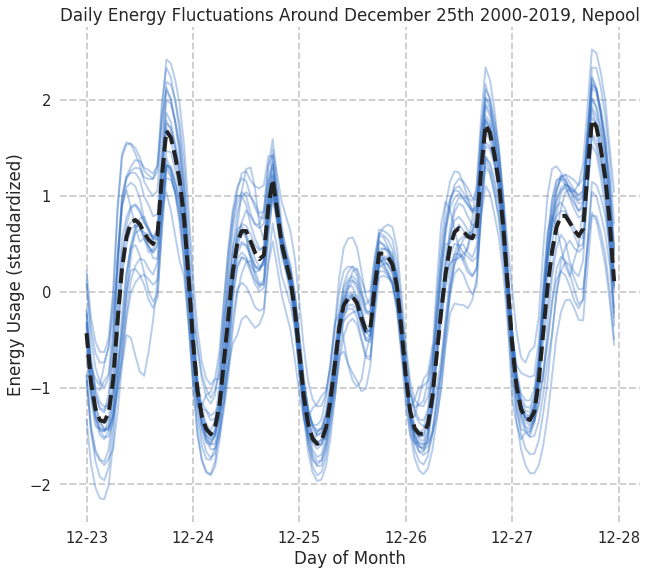

In [0]:
# christmas
y = 2000
d=1
m=2
l = []
fig = pl.figure()
ax = fig.add_subplot(111)
while y<2020:
  try:
    s = preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==12) & ((explore.index.day > 22) & (explore.index.day < 28))].values.flatten())
    if len(s) < 24:
      pass
    else:
      l.append(s)
    pl.plot(x, s, alpha=0.35, c='b')
  except:
    break
  y+=1
pl.plot(x, pd.DataFrame(np.stack(l)).mean(axis=0), '--', c='k', linewidth=4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
pl.xlabel("Day of Month")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuations Around December 25th 2000-2019, Nepool")

In [0]:
s = []
for h in range(24):
  s.append(np.mean(preprocessing.scale(explore["Nepool_Load_Hist"].loc[((explore.index.year > 2014) < 2020) & (explore.index.month==1) & (explore.index.hour==h)])))

Text(0.5, 1.0, 'Daily Energy Fluctuation in July from 2010-2019, Nepool')

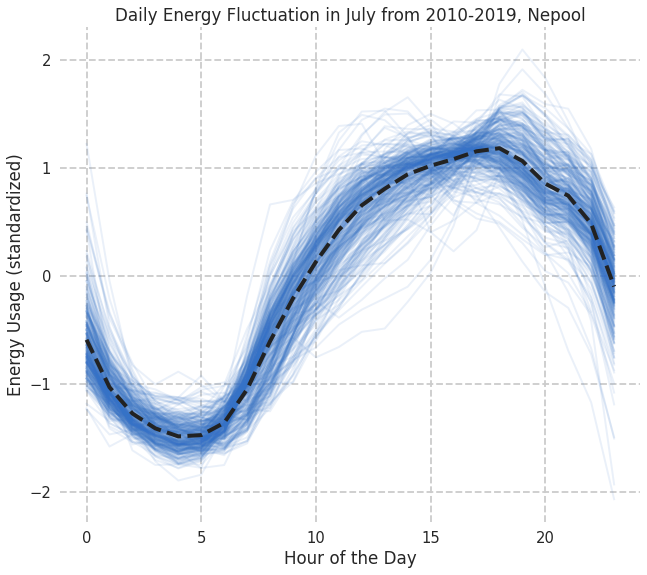

In [0]:
y = 2010
d=1
m = 7
l = []
while y<2020:
  while d < 32:
    try:
      s = preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten())

      if len(s) < 24:
        pass
      else:
        l.append(s)
      pl.plot(preprocessing.scale(explore["Nepool_Load_Hist"].loc[(explore.index.year==y) & (explore.index.month==m) & (explore.index.day==d)].values.flatten()), alpha=0.1, c='b')
    except:
      break
    d += 1
  d=1
  y+=1
pl.plot(np.arange(24), pd.DataFrame(np.stack(l)).mean(axis=0), '--', c='k', linewidth=4)
pl.xlabel("Hour of the Day")
pl.ylabel("Energy Usage (standardized)")
pl.title("Daily Energy Fluctuation in July from 2010-2019, Nepool")

# heat map

We created a heatmap which showed the weekly average for a certain amount of years.

In [0]:
import seaborn as sns

In [0]:
# 1 year
#startyear = 2016   # starting year for creating the heatmap
#for i in range(2, 52):
#  temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==startyear) & (explore.index.week==i)]
#  c = temp.groupby(temp.index.hour).mean()
#  o['%s' % i] = c

In [0]:
# y years
# run this code to produce the heatmap for any number of years

dates = []
startyear = 2016   # starting year for creating the heatmap
for y in range(3):
  if y==0:
    for i in range(1, 53):
      temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==startyear) & (explore.index.week==i)]
      dates.append(temp.index[0])
      c = temp.groupby(temp.index.hour).mean()
      o['%s' % i] = c
  else:
    for i in range(1, 53):
      temp = explore["Nepool_Load_Hist"].loc[(explore.index.year==(startyear+y)) & (explore.index.week==i)]
      dates.append(temp.index[0])
      c = temp.groupby(temp.index.hour).mean()
      o['%s' % (52*y+i)] = c

In [0]:
j = pd.DataFrame(preprocessing.scale(o), columns=o.columns)
j = j.T   # transpose to get the orientation correct
j = j.set_axis(dates)

[Text(65.50000000000001, 0.5, 'Month of Year'), Text(0.5, 53.8, 'Hour of Day')]

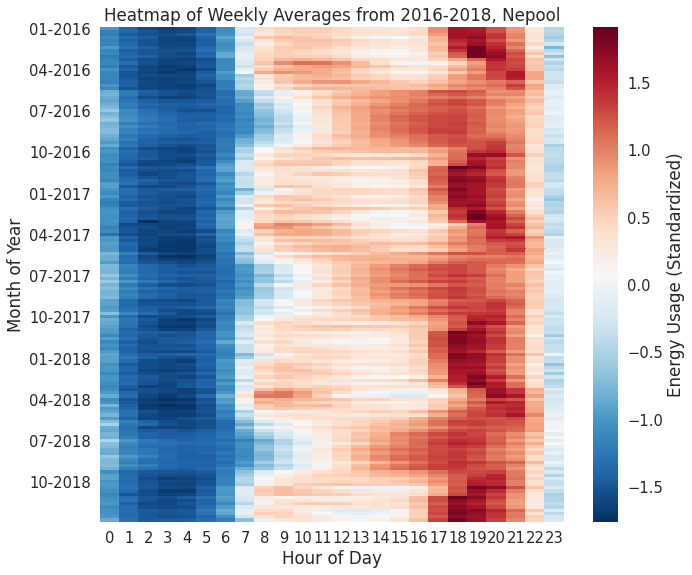

In [0]:
ax = sns.heatmap(j, cmap="RdBu_r", yticklabels=j.index.strftime('%m-%Y'), cbar_kws={'label': 'Energy Usage (Standardized)'})
for ind, label in enumerate(ax.get_yticklabels()):
    if ind % 13 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title('Heatmap of Weekly Averages from 2016-2018, Nepool')
ax.set(xlabel="Hour of Day", ylabel="Month of Year")

# contour plots

below is a contour plot of the density of the data, used to explore whether there are two populations in the data itself.

In [0]:
!pip install astroML
%pylab inline

     |████████████████████████████████| 112kB 11.4MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128665 sha256=16366084974e525793b41f00f9833f17bcd050adbcc573bfe71700c37972615c
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
from astroML.plotting import scatter_contour

Text(0, 0.5, 'energy usage (MWh)')

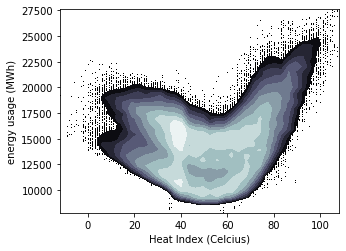

In [0]:
from astroML.plotting import scatter_contour
fig, ax = plt.subplots(figsize=(5, 3.75))
s = scatter_contour(mydata["KBOS_HID_HIST"], mydata["Nepool_Load_Hist"], threshold=30, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))
pl.xlabel("Heat Index (Celcius)")
pl.ylabel("energy usage (MWh)")

# Other Garbage

Included below is scrap work I did over the course of this project.  I wish to keep a lot of this since I did minor exploration through this code, but none of this is necessarily important for any reader of this script to go through.

In [0]:
d = mydata.loc[(mydata.index.year==2013) & (7 < mydata.index.month) & (mydata.index.month < 12)].index

In [0]:
actual = mydata.loc[(mydata.index.year==2013) & (7 < mydata.index.month) & (mydata.index.month < 12)]["Nepool_Load_Hist"]

In [0]:
predict = model.predict(mydata.loc[(mydata.index.year==2013) & (7 < mydata.index.month) & (mydata.index.month < 12)].drop("Nepool_Load_Hist", axis=1).to_numpy())

Text(0.5, 1.0, 'Predicted vs Actual Summer Energy Demand, 2012')

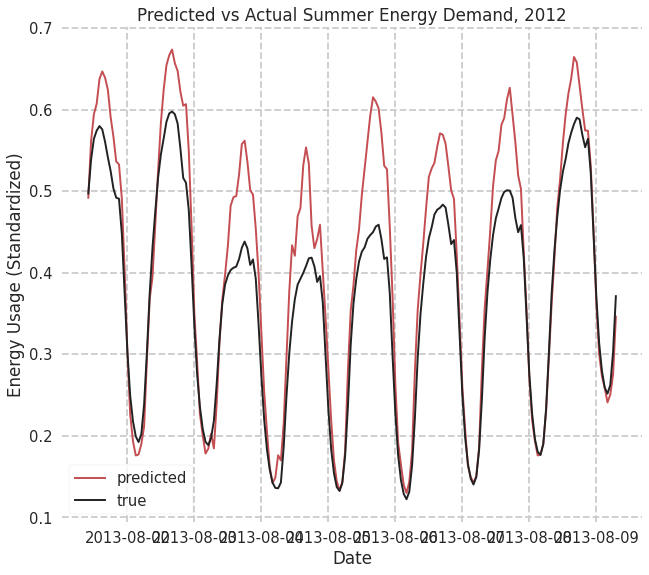

In [0]:
fig = pl.figure()
ax = fig.add_subplot(111)
s = 10
e = 200
pl.plot(d[s:e], predict.flatten()[s:e], 'r', label="predicted")
pl.plot(d[s:e], actual.values[s:e], 'k', label="true")
pl.legend()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
pl.ylabel("Energy Usage (Standardized)")
pl.xlabel("Date")
pl.title("Predicted vs Actual Summer Energy Demand, 2012")


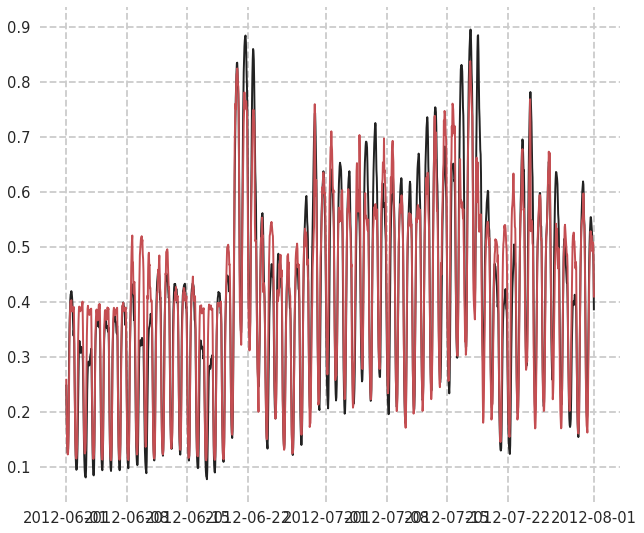

In [0]:
pl.plot(d, actual.values, 'k', label="true")
pl.plot(d, predict.flatten(), 'r', label="predicted")

In [0]:
l = []
rang = 3600
cheek = 240
for y in range(2010, 2012):
  for m in [2, 5, 8, 11]:
    model.load_weights("%s %s weights" % (y, m))
    strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]
    actual = mydata.iloc[strt:strt+rang]

    predict = model.predict(actual.drop(["Nepool_Load_Hist", "Date"], axis=1).to_numpy())
    actual = actual["Nepool_Load_Hist"]
    #pl.plot(np.abs((b["%s %s predict" % (y, m)].flatten() - b["%s %s actual" % (y, m)].values) /b["%s %s actual" % (y, m)].values),'.', c='k')
    l.append(np.abs((predict.flatten() - actual.values) /actual.values))
    #(1 / len(b["2011 %s predict"])) * np.sum(np.abs((b["2011 %s predict"] - b["2011 %s actual"]) /b["2011 %s actual"]))

In [0]:
print(l[0].mean())
print(l[1].mean())
print(l[2].mean())
print(l[3].mean())

0.13439814498773325
0.14999958511813885
0.12885826916451626
0.09153500819865511


In [0]:
print(l[0].mean())
print(l[1].mean())
print(l[2].mean())
print(l[3].mean())

0.12467594278216723
0.16608257562887085
0.1702187636558816
0.11553603373062239


In [0]:
print(l[0].mean())
print(l[1].mean())
print(l[2].mean())
print(l[3].mean())

0.13765895597061528
0.13197125647786445
inf
0.10263252566199586


In [0]:
np.mean(l)

0.13516304040832317

In [0]:
# rounding everything to the nearest hour, since some values are a little off
mydata = pd.read_excel('PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx')  #stat
mydata = mydata[['Date', 'KBOS_WCL_HIST', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]
mydata['Date'] = pd.to_datetime(mydata['Date']).dt.round('H')

In [0]:
# rounding everything to the nearest hour, since some values are a little off
mydata = pd.read_excel('PJM_NEPOOL_hourly_data_Jan2000_Jul2019.xlsx')  #stat
mydata = mydata[['Date', 'KBOS_WCL_HIST', 'KBOS_HID_HIST', 'Nepool_Load_Hist']]
mydata['Date'] = pd.to_datetime(mydata['Date']).dt.round('H')
# Creating dummy variables for month
a = [mydata['Date'][i].month for i in range(0, len(mydata))]
a = pd.get_dummies(a)
months = a.columns.values
for i in range(0, 11):
    mydata['Month%s' % (i+1)] = a.iloc[:, i]
    
# Creating dummy variables for hour
a = [mydata['Date'][i].hour for i in range(0, len(mydata))]
a = pd.get_dummies(a)
hours = a.columns.values
for i in range(0, 24):
    mydata['Hour%s' % (i+1)] = a.iloc[:, i]

# create dummy variable for holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=mydata["Date"].iloc[0], end=mydata["Date"].iloc[-1])
mydata["holiday"] = mydata["Date"].isin(holidays).astype(int)

# create dummy variable for weekend
l = []
for i in mydata["Date"]:
  if i.weekday() < 5:
    l.append(0)
  else:
    l.append(1)
mydata["weekend"] = l

mydata = mydata.dropna()

In [0]:
# create dummy variable for holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=mydata["Date"].iloc[0], end=mydata["Date"].iloc[-1])
mydata["holiday"] = mydata["Date"].isin(holidays).astype(int)

In [0]:
# create dummy variable for weekend
l = []
for i in mydata["Date"]:
  if i.weekday() < 5:
    l.append(0)
  else:
    l.append(1)
mydata["weekend"] = l

In [0]:
mydata = mydata.dropna()

In [0]:
l = []
rang = 3600
cheek = 240
for y in range(2010, 2012):
  for m in [2, 5, 8, 11]:
    model.load_weights("%s %s weights" % (y, m))
    strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]
    actual = mydata.iloc[strt:strt+rang]

    predict = model.predict(actual.drop(["Nepool_Load_Hist", "Date"], axis=1).to_numpy())
    actual = actual["Nepool_Load_Hist"]
    #pl.plot(np.abs((b["%s %s predict" % (y, m)].flatten() - b["%s %s actual" % (y, m)].values) /b["%s %s actual" % (y, m)].values),'.', c='k')
    l.append((predict.flatten() - actual.values))
    #(1 / len(b["2011 %s predict"])) * np.sum(np.abs((b["2011 %s predict"] - b["2011 %s actual"]) /b["2011 %s actual"]))

data = np.stack(l)
np.median(l)
frame1 = pl.hist(unnorm, bins=25)
pl.title("Histogram of Prediction Residuals")
pl.xlabel("Error (MWh)")
#pl.
unnorm = med*(mx - mn)


In [0]:
data = np.stack(l)
np.median(l)
frame1 = pl.hist(unnorm, bins=25)
pl.title("Histogram of Prediction Residuals")
pl.xlabel("Error (MWh)")
#pl.
unnorm = med*(mx - mn)


NameError: ignored

In [0]:
np.median(unnorm)

51.10730008781033

In [0]:
unnorm = med*(mx - mn)


NameError: ignored

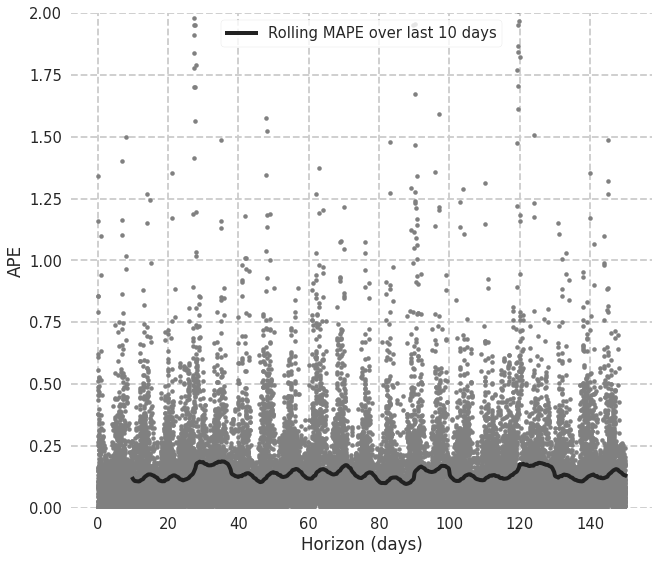

In [0]:
data = np.stack(l)
val = []
for i in range(rang - cheek):
  val.append(np.mean(data[:, i:(i+cheek)]))
np.arange(0, rang)/24
pl.plot(np.arange(0, rang)/24, data.T, '.', c='gray')
pl.plot(np.arange(cheek, rang)/24, val, c='k', linewidth=4, label="Rolling MAPE over last 10 days")
pl.ylim([0, 2])
pl.xlabel("Horizon (days)")
pl.ylabel("APE")
pl.legend()

In [0]:
l = []
rang = 2400
cheek = 240
for y in range(2010, 2013):
  for m in [2, 5, 8, 11]:
    model.load_weights("%s %s weights" % (y, m))
    strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]
    actual = mydata.iloc[strt:strt+rang]

    predict = model.predict(actual.drop(["Nepool_Load_Hist", "Date"], axis=1).to_numpy())
    actual = actual["Nepool_Load_Hist"]
    #pl.plot(np.abs((b["%s %s predict" % (y, m)].flatten() - b["%s %s actual" % (y, m)].values) /b["%s %s actual" % (y, m)].values),'.', c='k')
    l.append(np.abs((predict.flatten() - actual.values) /actual.values))
    #(1 / len(b["2011 %s predict"])) * np.sum(np.abs((b["2011 %s predict"] - b["2011 %s actual"]) /b["2011 %s actual"]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(0.0, 1.0)

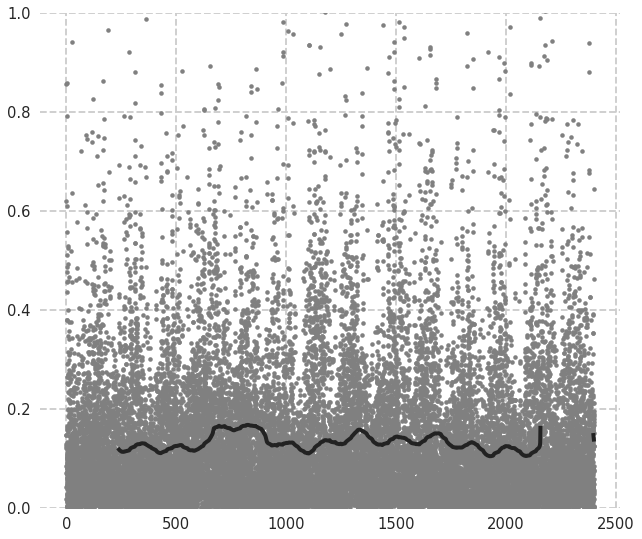

In [0]:
data = np.stack(l)
val = []
for i in range(rang - cheek):
  val.append(np.mean(data[:, i:(i+cheek)]))
pl.plot(data.T, '.', c='gray')
pl.plot(np.arange(cheek, rang), val, c='k', linewidth=4)
pl.ylim([0, 1])

In [0]:

# [2, 5, 8, 11]
y = 2010
m = 2
model.load_weights("%s %s weights" % (y, m))
strt = mydata.loc[(mydata["Date"].dt.year==y) & (mydata["Date"].dt.month==m)].index[0]
actual = mydata.iloc[strt:strt+1000]
dates = actual["Date"]
predict = model.predict(actual.drop(["Nepool_Load_Hist", "Date"], axis=1).to_numpy())
actual = actual["Nepool_Load_Hist"]

Text(0, 0.5, 'Energy (standardized)')

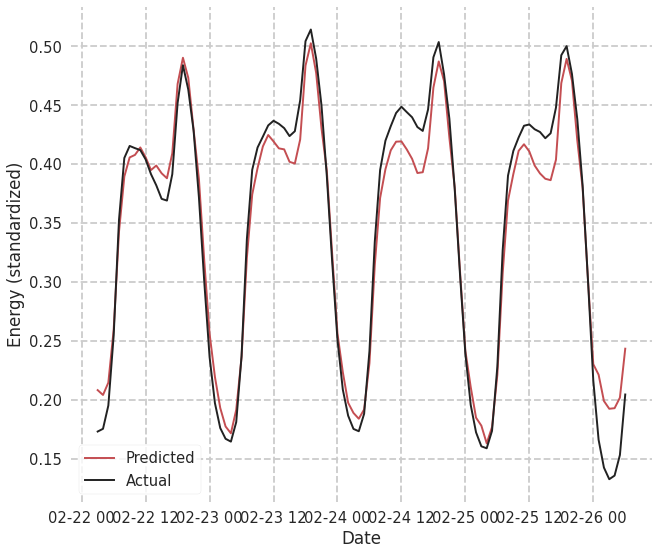

In [0]:
pl.plot(dates[500:600], predict.flatten()[500:600], label="Predicted", c='r')
pl.plot(dates[500:600], actual.values[500:600], label="Actual", c='k')
pl.legend()
pl.xlabel("Date")
pl.ylabel("Energy (standardized)")